# Gun Ownership and Covid Vaccination 

#### *AKA: Guns N Needles*


For this project, I will be looking into a relationship between gun ownership and Covid vaccination rates. The rationale behind this project is that I am trying to identify a proxy characteristic to predict the likelyhood of someone deciding to get the Covid vaccine or not. Through anecdotal experiences, I found that people I knew that chose to **not** get vaccinated did so with an independent spirit, with the mindset that the individual is responsible for their own health, not the collective. Likewise, I have anecdotal experiences with people that decided to purchase a firearm with similar logic, they held that the individual is responsible for their personal safety, and that the individual should not rely on the collective approach alone. Conversely, I have found that people that chose to get vaccinated often did so from sense of duty to the community, with the mindset that it is the responsibility of the individual to contribute to the collective, not for themselves alone. Similarly, I have encountered many people that have made the decision to not own a firearm because they believe in the collective approach to providing personal safety. Remarkably, while both gun ownership and the Covid vaccine tend to be controversial and polarizing topics, I have found that people on either side of both debates seem to agree with the logic that I am putting forward to connect these issues. However, here are a few obvious exceptions to this pattern:

- some people buy guns for reasons other than personal safety (i.e. hunting or sport shooting)
- some people that believe in guns for personal safety dont have them (i.e. too expensive, blocked from legal ownership)
- some people that dont believe in getting the Covid vaccine did so anyway (i.e. employment requirement, family request)
- some people that believe in the vaccine have not gotten it (i.e. health concerns, lack of availability)

With this project **I am not attempting to convice people to change their ideas or behavior**, rather I am trying to identify a hidden belief system that seems to influence people's idea and behavioral patterns. Understanding these belief systems could be useful for facilitating better discussion about these and other issues. 

### Data Sources
---
gun ownership rates data available [here](https://worldpopulationreview.com/state-rankings/gun-ownership-by-state)
downloadable as a csv or json file

state vaccination rates data available [here](https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations)
as a csv file called "us_state_vaccinations.csv"



## Getting The Data in Place

Here I am importing the two data sets linked above and assembling them into one pandas dataframe to work with. The vaccincation data set is very large and updated regularly for use with time series plotting, but I am only interested in the latest available data for the 50 US states so I select the data for the current date and drop the non-relevant locations. I only had to do a little transformation to get the data into the shape that I wanted. The gun ownership dataset was even more straight forward, but to combine the two I ran into an issue where one set used the label "New York State" and the other just "New York". To get around this I just sorted both sets alphabetically and merged them. I also wrote a function to categorize each state as high or low rates of gun ownership (based on above or below the group mean) to add a categorical lens to the data. 

In [1]:
# import libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
# set pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
# set visualization theme
sns.set_theme(
    context='notebook',
    style='darkgrid', 
    palette='deep',
    font='sans-serif',
    font_scale=1.3,
    color_codes=True,
    rc=None
)


### Vaccination Data Set

In [4]:
# importing vaccination data
raw_vax = pd.read_csv('us_state_vaccinations.csv')
raw_vax.head(1)

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207


In [44]:
# selecting only US states
drop = ['Veterans Health', 'Virgin Islands', 'United States', 'Republic of Palau', 'Puerto Rico', 
        'Northern Mariana Islands', 'Marshall Islands', 'Indian Health Svc', 'Guam', 'Dept of Defense',
        'District of Columbia', 'Federated States of Micronesia', 'Bureau of Prisons', 'American Samoa']

# selecting for currents date
mask = raw_vax['date'] >= '2021-10-09'
vax = raw_vax[mask].copy()

mask = vax['location'].isin(drop)

vax.drop(vax.loc[mask,:].index, axis=0, inplace=True)
vax.reset_index(drop=True, inplace=True)
# adding state population
vax['population'] = (
                        (vax['people_fully_vaccinated']) / 
                        (vax['people_fully_vaccinated_per_hundred'] / 100)
                    ).astype(int)

# selecting columns
vaxed = vax[['location','people_fully_vaccinated_per_hundred', 'population', 'people_fully_vaccinated']].copy()
vaxed.head()
   

,location,people_fully_vaccinated_per_hundred,population,people_fully_vaccinated
0,Alabama,43.42,4903099,2128926.0
1,Alaska,51.17,731606,374363.0
2,Arizona,51.77,7278566,3768114.0
3,Arkansas,46.32,3017549,1397729.0
4,California,59.75,39509390,23606861.0


In [46]:
# adding columns
vaxed['% unvaccinated'] = 100 - vaxed['people_fully_vaccinated_per_hundred']
vaxed['people_unvaccinated'] = vaxed['population'] - vaxed['people_fully_vaccinated']

vaxed.head(3)

,location,people_fully_vaccinated_per_hundred,population,people_fully_vaccinated,% unvaccinated,people_unvaccinated
0,Alabama,43.42,4903099,2128926.0,56.58,2774173.0
1,Alaska,51.17,731606,374363.0,48.83,357243.0
2,Arizona,51.77,7278566,3768114.0,48.23,3510452.0


Vaccination data set ready to roll


### Gun Ownership Data Set

In [49]:
# uploading gun owner data
guns = pd.read_csv('gun_owner_percent_by_state.csv')

# reordering alpahbetically to resolve "new york"/"new york state" conflict
shooters = guns.sort_values('State').reset_index(drop=True)

guns.head(3)

,State,gunOwnership,totalGuns
0,New Jersey,0.147,57505
1,Massachusetts,0.147,37152
2,Rhode Island,0.148,4223


### Combining Data Sets

In [51]:
# adding gun owner data to vaccination data set
vaxed['% gun owners'] = shooters['gunOwnership']*100
vaxed['total guns'] = shooters['totalGuns']

vaxed.head()

,location,people_fully_vaccinated_per_hundred,population,people_fully_vaccinated,% unvaccinated,people_unvaccinated,% gun owners,total guns
0,Alabama,43.42,4903099,2128926.0,56.58,2774173.0,55.5,161641
1,Alaska,51.17,731606,374363.0,48.83,357243.0,64.5,15824
2,Arizona,51.77,7278566,3768114.0,48.23,3510452.0,46.3,179738
3,Arkansas,46.32,3017549,1397729.0,53.68,1619820.0,57.2,79841
4,California,59.75,39509390,23606861.0,40.25,15902529.0,28.3,344622


In [52]:
# sorting dataframe by % unvaccinated
v_ordered = vaxed.sort_values('% unvaccinated').reset_index(drop=True).copy()

# adding columns
v_ordered['gun owners'] = (v_ordered['population'] * (v_ordered['% gun owners'] / 100)).astype(int)
v_ordered['non gun owners'] = (v_ordered['population'] - v_ordered['gun owners']).astype(int)
v_ordered['% vaccinated'] = 100 - v_ordered["% unvaccinated"]

v_ordered.head(3)

,location,people_fully_vaccinated_per_hundred,population,people_fully_vaccinated,% unvaccinated,people_unvaccinated,% gun owners,total guns,gun owners,non gun owners
0,Vermont,70.15,624018,437749.0,29.85,186269.0,50.5,5872,315129,308889
1,Connecticut,69.41,3565515,2474824.0,30.59,1090691.0,23.6,82400,841461,2724054
2,Rhode Island,69.26,1059332,733694.0,30.74,325638.0,14.8,4223,156781,902551


In [151]:
# adding state classifications for +- national average gun ownership rates
def classify_guns(percent_gun_owners):
    if percent_gun_owners >= v_ordered['% gun owners'].mean():
        return 'High Gun Ownership'
    else: return 'Low Gun Ownership'
    
# adding a classification for +- national average state populations
def classify_pops(state_population):
    if state_population >= v_ordered['population'].median():
        return 'high_population'
    else: return 'low_population'
    
v_ordered['Gun Rate'] = v_ordered['% gun owners'].apply(classify_guns)
v_ordered['population_type'] = v_ordered['population'].apply(classify_pops)

v_ordered.head()


,location,people_fully_vaccinated_per_hundred,population,people_fully_vaccinated,% unvaccinated,people_unvaccinated,% gun owners,total guns,gun owners,non gun owners,state_type,% vaccinated,gun_type,population_type,Gun Rate
0,Vermont,70.15,624018,437749.0,29.85,186269.0,50.5,5872,315129,308889,low_population,70.15,High Gun Ownership,low_population,High Gun Ownership
1,Connecticut,69.41,3565515,2474824.0,30.59,1090691.0,23.6,82400,841461,2724054,low_population,69.41,Low Gun Ownership,low_population,Low Gun Ownership
2,Rhode Island,69.26,1059332,733694.0,30.74,325638.0,14.8,4223,156781,902551,low_population,69.26,Low Gun Ownership,low_population,Low Gun Ownership
3,Maine,69.11,1344126,928926.0,30.89,415200.0,46.8,15371,629050,715076,low_population,69.11,High Gun Ownership,low_population,High Gun Ownership
4,Massachusetts,68.46,6892142,4718361.0,31.54,2173781.0,14.7,37152,1013144,5878998,low_population,68.46,Low Gun Ownership,high_population,Low Gun Ownership


## Visualizing The Data
I use a scatter plot to visualize the relationship between vaccination rates. I also added a regression line (using ordniary least squares) to add some directional context. The second chart is a kernal density estimation plot that shows the variance in vaccination rate distribution between states with above and below average gun ownership rates. 

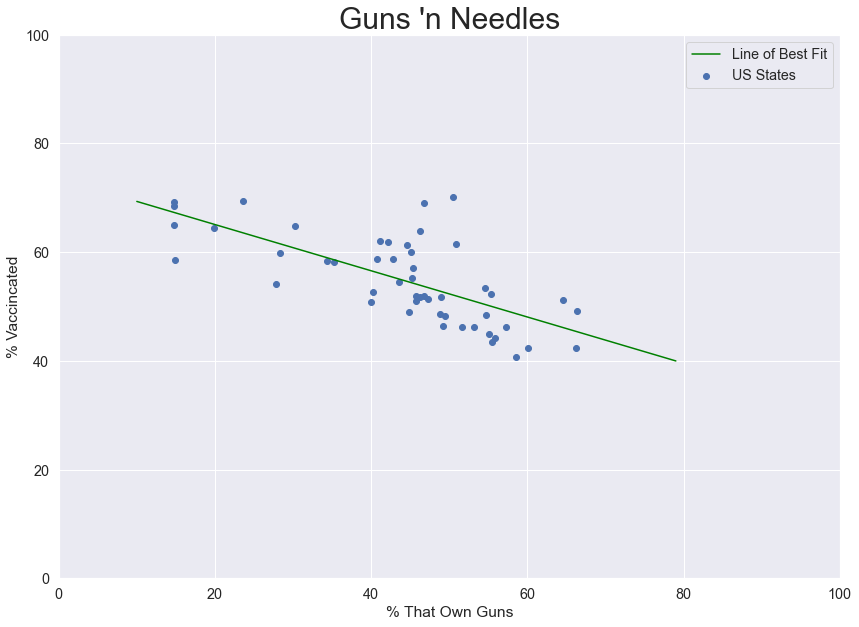

In [192]:
plt.figure(figsize=(14,10))

plt.scatter(v_ordered['% gun owners'], v_ordered['% vaccinated'], label='US States')

# regression line for % gun owners
y = v_ordered['% vaccinated']
x = v_ordered['% gun owners']
m, b = np.polyfit(x, y, 1)
a = np.arange(10,80,1)
plt.plot(a, m*a + b, color='green', label='Line of Best Fit')

plt.xlim([0,100])
plt.ylim([0,100])
plt.ylabel('% Vaccincated')
plt.xlabel('% That Own Guns')
plt.title("Guns 'n Needles", fontdict={'fontsize':30})
plt.legend()

plt.show()

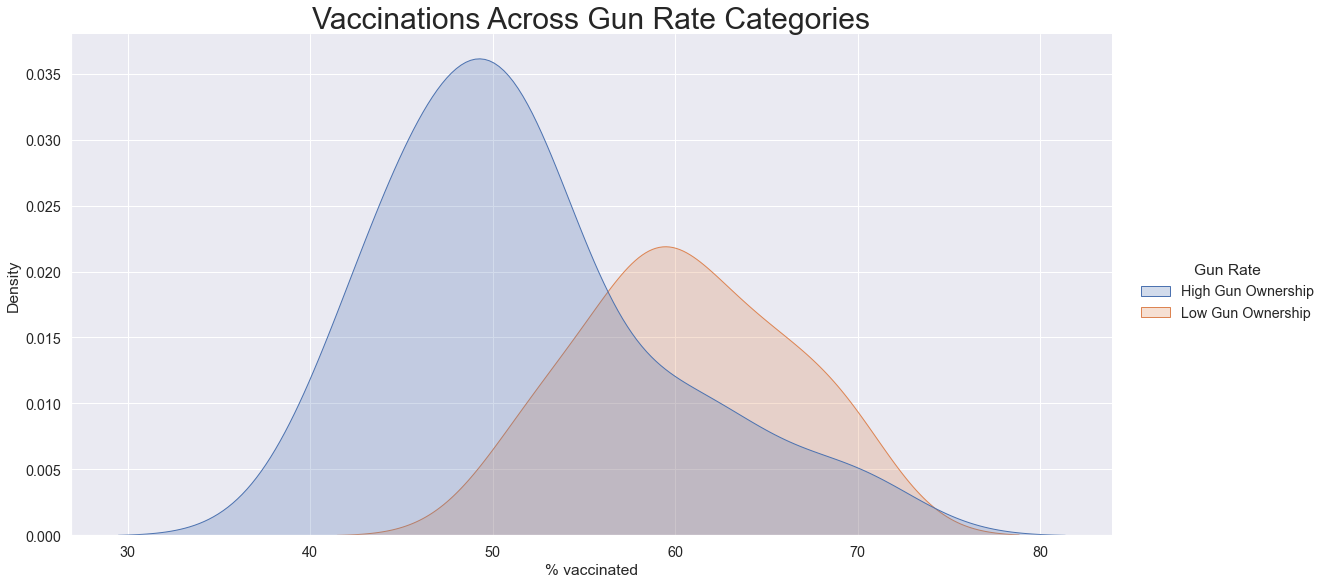

In [195]:
sns.displot(v_ordered, x="% vaccinated", hue='Gun Rate', kind="kde", fill=True, height=8, aspect=2)
plt.title("Vaccinations Across Gun Rate Categories", fontdict={'fontsize':30})
plt.show()

## Statistical Measures

The first measures are the correlation coefficient and the r squared value. I used these measures to determine the level of relationship between gun ownership and vaccination rate. Here, the correlation coefficient tells us that gun ownership has a fairly strong negative relationship, and the r square value tells us that about 49% of the variation in vaccination rates can be attributed to a correlation with gun ownership. Important to remember that I am **not** trying to establish causality here, just showing that a strong correlation seems to exist. 

The second measures are t tests that I am using to show that there is a high improbability that relationship between gun ownership rates and vaccination rates is due to random chance rather than a real correlation. I'll go into these tests in more detail below.

In [198]:
# doing a Pearson r test to determine relationship between % unvaccinated and % gun owners

data = v_ordered[['% vaccinated', '% gun owners']].copy()

vax_mean = data['% vaccinated'].mean()
guns_mean = data['% gun owners'].mean()

print(f"vaccinated mean = {unvax_mean:1.2f}%")
print(f"Gun Ownership mean = {guns_mean:1.2f}%")

data['vax_variance'] = data['% vaccinated'] - vax_mean
data['gun_variance'] = data['% gun owners'] - guns_mean

data['vax_squared'] = data['vax_variance']**2
data['gun_squared'] = data['gun_variance']**2

vax_ss = data['vax_squared'].sum()
gun_ss = data['gun_squared'].sum()

print(f"Vaccinated SS = {vax_ss:1.2f}")
print(f"Gun Ownership SS = {gun_ss:1.2f}")

data['cross_products'] = data['vax_variance'] * data['gun_variance']

sum_products = data['cross_products'].sum()
print(f"Sum of products = {sum_products:1.2f}")

sample_n = data['cross_products'].count() - 1

sample_covariance = sum_products / sample_n
print(f"Sample Covariance = {sample_covariance}")

r = sum_products / (np.sqrt(vax_ss) * np.sqrt(gun_ss))
print(f"The r value, or correlation coefficient is {r:1.3f}")

print(f"The r square value is {r**2:1.3f}")

vaccinated mean = 45.17%
Gun Ownership mean = 44.10%
Vaccinated SS = 3175.28
Gun Ownership SS = 8518.85
Sum of products = -3622.95
Sample Covariance = -73.93768857142858
The r value, or correlation coefficient is -0.697
The r square value is 0.485


# First T Test

For the first t the states act as my samples and I am splitting them into two equal sized groups based on gun ownership rates. Then, I am comparing the distributions of the two group's vaccination rates to see how likely it is that the difference in vaccination rates between the two groups is due to random chance. 

For this test my null hypothesis is: 
- There is no difference in vaccination rates between states with gun ownership rates above 46% and states with gun ownership rates below 46%. 

For now, my alternative hypothesis is:
- There is a difference in vaccination rates between states with gun ownership rates above 46% and states with gun ownership rates below 46%.

I am setting my alpha at 5% and using the independant t test since the samples are two seperate groups. One other note is that the variance in vaccination rates is different between the two groups, so I will Welch's t test that does not assume equal variance. 

With the P value of .01% for this test well below the 5% threshold I set, I feel quite confident in discarding this null hypothesis and stating that there is a difference in vaccination rates between states with gun ownership rates above or below 46%.

In [206]:
# splitting the vaccinated data into gun owner and non gun owner states

gun_owner_state_mask = v_ordered['% gun owners']>46
non_go_state_mask = v_ordered['% gun owners']<= 46

v_mean_go = v_ordered['% vaccinated'][gun_owner_state_mask].mean()
v_mean_ngo = v_ordered['% vaccinated'][non_go_state_mask].mean()

gun_dict = {
    'gun states':v_ordered['% vaccinated'][gun_owner_state_mask].reset_index(drop=True),
    'non gun states':v_ordered['% vaccinated'][non_go_state_mask].reset_index(drop=True),                
}

guns = pd.DataFrame(gun_dict)

print(f"'Gun State' variance:\n{guns['gun states'].var()}\n")
print(f"'Non-Gun State' variance:\n{guns['non gun states'].var()}")


'Gun State' variance:
61.836358333333344

'Non-Gun State' variance:
33.79733766666667


In [164]:
# Here I am calculating the test statistic longhand
numerator = guns['gun states'].mean() - guns['non gun states'].mean()

n1 = guns['gun states'].count()
n2 = guns['non gun states'].count()

s1 = guns['gun states'].var()
s2 = guns['non gun states'].var()

denominator = np.sqrt((((n1 - 1)*s1 + (n2 -1)*s2) / (n1 + n2 -2)) * ((n1 + n2) / (n1 * n2)))

t = (numerator / denominator) 

t

-4.290104822066397

In [208]:
# Here I am using the scipy library to calculate the test statistic and and calculate the P value 

from scipy.stats import ttest_ind

stat, pval = ttest_ind(guns['gun states'],guns['non gun states'], equal_var=False )

print(f"test statistic:{stat}\n\nP value:{pval*100:.5f}% ")

test statistic:-4.290104822066405

P value:0.00957% 


## Second T Test

Here I am comparing the gun ownership distribution to the vaccinated and unvaccinated distribution. I am still working on both these tests to ensure validity, but I wanted to include them for now anyway. Here we see a very low likelihood that the differences in vaccination rate and gun ownership are due to chance alone, but a very high likelihood that unvaccinated rates and gun ownership rates could be due to random chance. 

In [210]:
from scipy.stats import ttest_rel

stat, pval = ttest_rel(v_ordered['% gun owners'], v_ordered['% vaccinated'] )

print(f"{pval*100:.5f}%")

stat, pval = ttest_rel(v_ordered['% gun owners'], v_ordered['% unvaccinated'])

print(f"{pval*100:.5f}%")

0.03347%
43.07120%


# ... Still In Progress

Still to come
- power test to determine likelyhood of alternative hypothesis
- summary review
- next steps